# Sentinel 2 CH4 Multi Band Multi Pass Mapper

## Overview
Sentinel 5’s resolution is very coarse, so to help users locate emission plumes relative to a landfill, Sentinel 2’s MSI instrument with a 20m2 spatial resolution and return frequency of 3-5 days was employed. 

Varon et al. (2021) showed that methane plumes from point sources could be imaged by differencing Sentinel-2’s SWIR-1 and SWIR-2 bands. The tool runs an analysis using a similar multi-band-multi-pass retrieval method: 

First it calculates a multi-band-single-pass calculation for both active emission and no emission dates, resulting in two datasets which are then used together for a multi-band-multi-pass method. 
The multi-band-single-pass equation is as follows: 


<div align="center"><b>MBSP = B11 - cB12</b></div>

Where:
- B12 is the Sentinel-2 SWIR-2 band.
- B11 is the Sentinel-2 SWIR-1 band. 
- c is calculated using the difference in the median of B12 to B11 and then adding the difference to B12.  

Once active emission and no emission scenes have been calculated, the following equation is used to calculate the multi-band-multi-pass raster. 

<div align="center"><b>MBMP = ActiveMBSP − NoMBSP</b></div>

Where:
- ActiveMBSP is the multiband single pass for the active emission scene
- NoMBSP is the multiband single pass for the no emission scene.  

The dates for the 'active_emission_data' and 'no_emission_data' can be determined by using the Sentinel 5P Time Series, or Sentinel 5P CH4 Map tools. If you run into any difficulty, please refer to section 4.3 in the How to guide. 

The section below imports the packages needed to run the script.

In [1]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import openeo
import rasterio
import numpy as np
import requests
from sklearn.linear_model import LinearRegression

## Connect to OpenEO

The code below establishes a connection with the Copernicus openEO platform which provides a wide variety of earth observation datasets

- If this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section 2.6 of the user guide. 

- If you have followed the steps in section 2.6 correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 

- If there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## View list of landfills. 

Each landfill has been asigned an id number. This number can be found in the list produced by the following code. To look at a chosen landfill, you will need to input that number at various stages in the code. Run the code below to the the list. The west, south, east and north columns are latitude and longitude cordinates to establish a box around each landfill for analysis.  

In [3]:
landfill_csv = pd.read_csv(r'C:\GIS_Course\Landfill_Atmospheric_Gas_Monitor_Tools\Data\PreZero_Landfill_Bounding_large.csv')
# landfill_csv = pd.read_csv(r'C:\GIS_Course\Landfill_Atmospheric_Gas_Monitor_Tools\Data\PreZero_Landfill_Bounding_small.csv')
landfill_csv

,id,Landfill,west,south,east,north
0,0,ALBACETE,-1.911597,38.889855,-1.642103,39.099308
1,1,ALBOX: MANCOMUNIDAD ALMANZORA LEVANTE,-2.308716,37.283577,-2.039221,37.497694
2,2,ALCALA DEL RIO (LA VEGA-SEVILLA),-6.134197,37.492421,-5.864703,37.705942
3,3,ALCAZAR DE SAN JUAN (COMPLEJO): COMSERMANCHA,-3.359847,39.328849,-3.090352,39.536998
4,4,ALMERIA: CMA,-2.421493,36.771086,-2.151999,36.986656
5,5,CAN MATA (ELS HOSTALETS DE PIEROLA): DC,1.671640,41.429973,1.941135,41.631717
6,6,CANADA HERMOSA: MURCIA,-1.422826,37.874464,-1.153332,38.086885
7,7,DAIMIEL,-3.719345,38.959895,-3.449850,39.169141
8,8,ECOPARQUE DE TOLEDO: GESMAT,-4.298551,39.757747,-4.029057,39.964611
9,9,ECOPARQUE GRAN CANARIA NORTE (SALTO DEL NEGRO),-46.315629,27.939845,46.225798,28.177665


# Available dates for the analysis. 

Unlike Sentinel 5P, Sentinel 2 only provides data aproximately once every 3 days. Because of this, not every date you can enter into this tool is valid. The code below will tell you what dates are available to use for the landfill of your choice. 

The two parameters you need to modify before running the code are: 
- landfill_id = 23 (change this to your chosen landfill) 
- temporal_extent = ["2023-01-31", "2023-03-12"] (change this to your chosen date range using "YYYY-MM-DD" format)

Once you have done this run the code and the available dates should appear below in a matter of a few seconds. 

In [151]:
def get_spatial_extent(landfill_id):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]
    return {
        "west": landfill['west'],
        "south": landfill['south'],
        "east": landfill['east'],
        "north": landfill['north']
    }

def fetch_available_dates(landfill_id, temporal_extent):
    spatial_extent = get_spatial_extent(landfill_id)
    catalog_url = f"https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json?box={spatial_extent['west']}%2C{spatial_extent['south']}%2C{spatial_extent['east']}%2C{spatial_extent['north']}&sortParam=startDate&sortOrder=ascending&page=1&maxRecords=1000&status=ONLINE&dataset=ESA-DATASET&productType=L2A&startDate={temporal_extent[0]}T00%3A00%3A00Z&completionDate={temporal_extent[1]}T00%3A00%3A00Z&cloudCover=%5B0%2C{cloud_cover}%5D"
    response = requests.get(catalog_url)
    response.raise_for_status()
    catalog = response.json()
    dates = [date.split('T')[0] for date in map(lambda x: x['properties']['startDate'], catalog['features'])]
    return dates

# Please enter your perameters here.
landfill_id = 23  # Specify the landfill ID.
temporal_extent = ["2021-01-01", "2021-12-30"]  # Specify the the date range you want to check for available data.
cloud_cover = 15

available_dates = fetch_available_dates(landfill_id, temporal_extent)
print("Available dates:", available_dates)

Available dates: ['2021-01-08', '2021-01-13', '2021-01-18', '2021-01-23', '2021-02-07', '2021-03-09', '2021-03-19', '2021-04-13', '2021-04-23', '2021-04-28', '2021-05-08', '2021-05-18', '2021-06-17', '2021-07-17', '2021-07-27', '2021-08-01', '2021-08-06', '2021-08-11', '2021-08-26', '2021-09-15', '2021-09-25', '2021-10-05', '2021-10-15', '2021-10-15', '2021-10-20', '2021-10-20', '2021-10-30', '2021-10-30', '2021-11-14', '2021-11-19', '2021-11-24', '2021-12-14', '2021-12-24', '2021-12-29', '2021-12-29']


## Choosing the Active Emission Date

As mentioned in the overview, an active emission date must be chosen from one of the available datasets. 

Like before, the two parameters you need to modify before running the code are:

- landfill_id = 23 (change this to your chosen landfill)
- temporal_extent = ["2023-02-25", "2023-02-25"] (change this to your chosen date range using "YYYY-MM-DD" format.) 

Please note that the temporal extent dates <u>MUST BE IDENTICAL</u> because we are only choosing a single date.

If you recieve an error message of 'NoDataAvailable' then please check the list of available data above and try again.


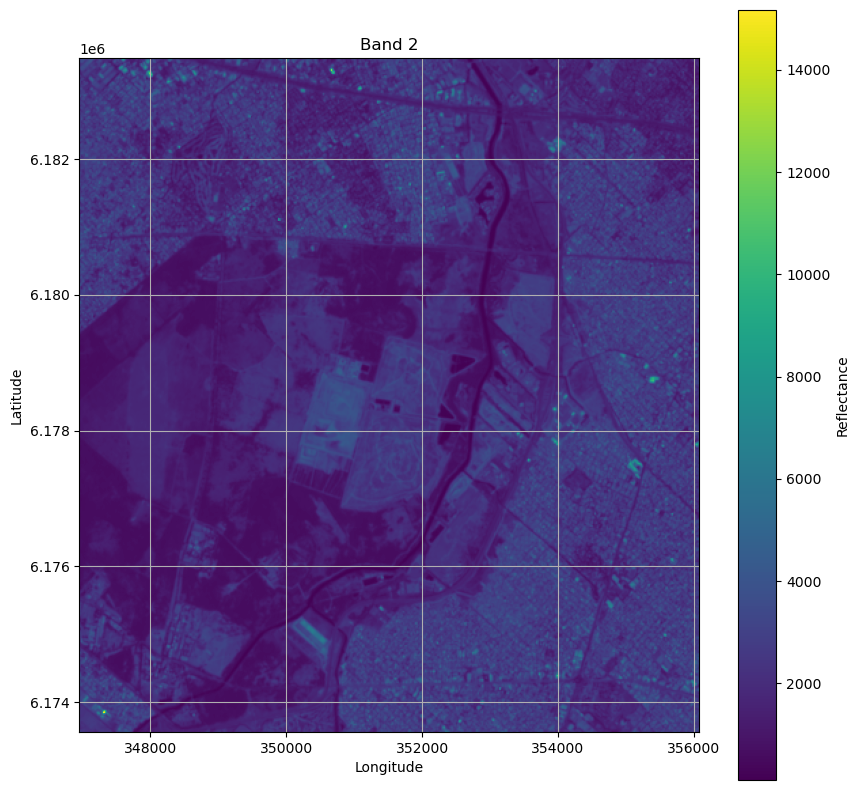

In [160]:
def active_emission(landfill_id, temporal_extent):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]

    active_emission = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent={
            "west": landfill['west'],
            "south": landfill['south'],
            "east": landfill['east'],
            "north": landfill['north']
        },
        bands=["B11", "B12"],
    )
    active_emission.download("Sentinel-2_active_emissionMBMP.GTiff")

# Enter perameters for the active emission day
landfill_id = 23  # Specify the landfill ID
temporal_extent = ["2021-12-29", "2021-12-29"]

active_emission(landfill_id, temporal_extent)

def plot_band(geotiff_file, band):
    with rasterio.open(geotiff_file) as src:
        band_data = src.read(band)
        extent = src.bounds
        plt.figure(figsize=(10, 10))
        plt.imshow(band_data, extent=[extent.left, extent.right, extent.bottom, extent.top])
        plt.colorbar(label='Reflectance')
        plt.title(f'Band {band}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True)
        plt.show()

# Path to the downloaded GeoTIFF file
geotiff_file = "Sentinel-2_active_emissionMBMP.GTiff"

# Plot Band B12
plot_band(geotiff_file, 2)  # B12 is the second band (indexing starts from 1)

## Choosing the No Emission Date

Next we choose the no emission date using the same process. 

The two parameters you need to modify before running the code are:

- landfill_id = 23 (change this to your chosen landfill)
- temporal_extent = ["2023-02-25", "2023-02-25"] (change this to your chosen date range using "YYYY-MM-DD" format.) 

The temporal extent dates <u>MUST BE IDENTICAL</u>

If you recieve an error message of 'NoDataAvailable' then please check the list of available data above and try again.


In [153]:
def no_emission(landfill_id, temporal_extent):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]

    no_emission_collection = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent={
            "west": landfill['west'],
            "south": landfill['south'],
            "east": landfill['east'],
            "north": landfill['north']
        },
        bands=["B11", "B12"],
    )
    no_emission_collection.download("Sentinel-2_no_emissionMBMP.GTiff")

# Enter parameters for the no emission day
landfill_id = 23 # Specify the landfill ID
temporal_extent = ["2021-01-08", "2021-01-08"]

no_emission(landfill_id, temporal_extent)

## Choosing a Background Satelite Image

This section helps with locating the source of the emission at the landfill by displaying a true colour satelite image of the landfill that the data will be superimposed over. I recommend choosing the same date as your active emission. 

Once again, the two parameters you need to modify before running the code are:

- landfill_id = 23 (change this to your chosen landfill)
- temporal_extent = ["2023-02-25", "2023-02-25"] (change this to your chosen date range using "YYYY-MM-DD" format.)

The temporal extent dates <u>MUST BE IDENTICAL</u>

If you recieve an error message of 'NoDataAvailable' then please check the list of available data above and try again.

In [154]:
def truecolour_image(landfill_id, temporal_extent):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]

    truecolour_image_collection = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent={
            "west": landfill['west'],
            "south": landfill['south'],
            "east": landfill['east'],
            "north": landfill['north']
        },
        bands=["B02", "B03", "B04"],
    )
    truecolour_image_collection.download("Sentinel-2_truecolour.GTiff")

# Enter parameters for the no emission day
landfill_id = 23  # Specify the landfill ID
temporal_extent = ["2021-01-08", "2021-01-08"]

truecolour_image(landfill_id, temporal_extent)

## Running the Analysis
Here, no modification by you is needed. The code below runs the analysis.  Provided all the variables above have been run correctly, this next section should take moments to complete. 

In [161]:
# Define file paths
Active_Multiband = "Sentinel-2_active_emissionMBMP.GTiff"
No_Multiband = "Sentinel-2_no_emissionMBMP.GTiff"

# Define each band from both datasets
with rasterio.open(Active_Multiband) as Active_img, rasterio.open(No_Multiband) as No_img:
    Active_B11 = Active_img.read(1)
    Active_B12 = Active_img.read(2)
    No_B11 = No_img.read(1)
    No_B12 = No_img.read(2)
    # Calculate the median difference for Active_B11 and Active_B12
    median_diff_active = np.median(Active_B11) - np.median(Active_B12)
    # Adjust Active_B12
    Corrected_Active_B12 = Active_B12 + median_diff_active
    # Calculate the median difference for No_B11 and No_B12
    median_diff_no = np.median(No_B11) - np.median(No_B12)
    # Adjust No_B12
    Corrected_No_B12 = No_B12 + median_diff_no
    # Calculate the fractional change
    frac_change = (Active_B11 - Corrected_Active_B12) - (No_B11 - Corrected_No_B12)

frac_change_max = np.max(frac_change)
frac_change_min = np.min(frac_change)
frac_change_mean = np.mean(frac_change)
frac_change_std = np.std(frac_change)

print("Maximum value of frac_change:", frac_change_max)
print("Minimum value of frac_change:", frac_change_min)
print("Mean value of frac_change:", frac_change_mean)
print("Standard deviation of frac_change:", frac_change_std)


Maximum value of frac_change: 1765.0
Minimum value of frac_change: -4891.0
Mean value of frac_change: 79.14393746366956
Standard deviation of frac_change: 191.39070136624565


## Viewing the data. 

This section of code can be run to produce the map. There is one piece of code that can be altered if needed. 

- brightness_factor = 0.05 (occasionally the true colour satelite image can be too bright or too dark. You can change this number to fix it)

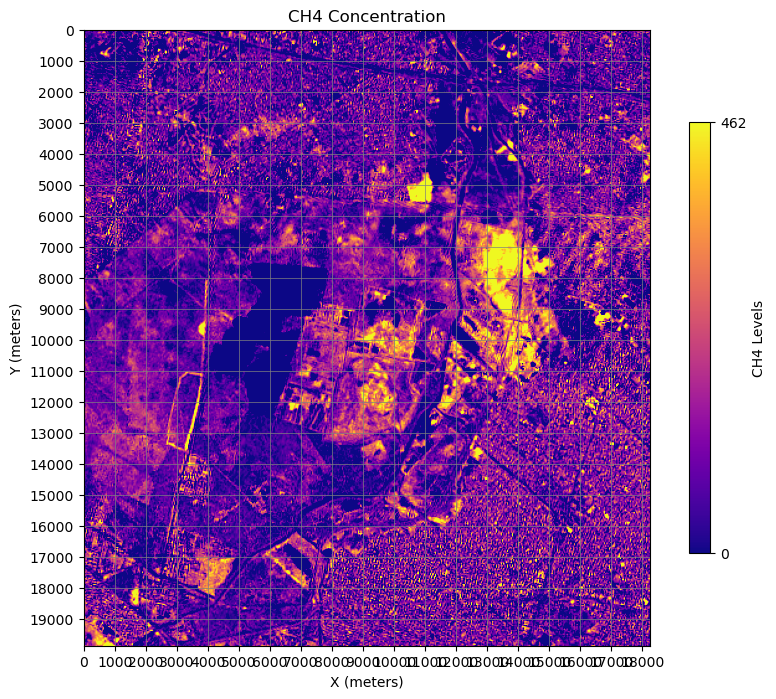

In [162]:
# Open the and load the truecolour satellite image file and define which band is which.
fp = 'Sentinel-2_truecolour.GTiff'
img = rasterio.open(fp)
blue = img.read(1)
green = img.read(2)
red = img.read(3)

# Change this number up or down if the satellite background image is too dark or bright. 
brightness_factor = 0.05 
blue = np.clip(blue * brightness_factor, 0, 255)
green = np.clip(green * brightness_factor, 0, 255)
red = np.clip(red * brightness_factor, 0, 255)

# Stack the blue, green and red bands to make a colour image. 
rgb = np.dstack((red, green, blue))
rgb = rgb / rgb.max()

# Create a new figure
plt.figure(figsize=(10, 8))

# Display the RGB image
plt.imshow(rgb)

# Calculate mean and standard deviation of frac_change
mean = np.nanmean(frac_change)
std = np.nanstd(frac_change)

# Create a mask where values are not 1.5 SD above the mean
mask = frac_change < (mean + 1 * std)

# Apply the mask
masked_frac_change = np.ma.masked_array(frac_change, mask=mask)

# Set vmin to zero and vmax to mean + 1 SD
mean = np.nanmean(frac_change)
std = np.nanstd(frac_change)
vmin = 0
vmax = mean + 2 * std

# Display the masked_frac_change data on top of the RGB image
plt.imshow(frac_change, cmap='plasma', alpha=1, vmin=vmin, vmax=vmax)

# Add a colorbar and labels
cbar = plt.colorbar(label='CH4 Levels', shrink=0.7)
cbar.set_ticks([vmin, vmax])
# cbar.set_ticklabels(['Lower', 'Higher'])
plt.title('CH4 Concentration')

# Dataset resolution in metres
resolution = 20  
	
# Get the dimensions of the image
height, width, _ = rgb.shape

# Create arrays representing the x and y coordinates in meters
x = np.arange(0, width * resolution, 1000)
y = np.arange(0, height * resolution, 1000)

# Set the x and y ticks and labels
plt.xticks(x / resolution, x)
plt.yticks(y / resolution, y)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

# Add grid lines
plt.grid(color='gray', linestyle='-', linewidth=0.5)

# Please enter the emission date where it says '[emission date here]' if you want to download more than one map.
plt.savefig(f'S2HRM[emission_date_here].jpg', format='jpg', bbox_inches='tight')

# Show the plot
plt.show()


## Interpreting this map

- The map above will show methane clouds in blue, purple and pink.
- Methane sources should show as bright orange and yellow points. 